In [152]:
import os
from dotenv import load_dotenv
load_dotenv()


os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["NVIDIA_API_KEY"]=os.getenv("NVIDIA_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANG_CHAIN_API_KEY")


In [153]:
# from langchain_nvidia_ai_endpoints import ChatNVIDIA
# code_llm = ChatNVIDIA(model="qwen/qwen2.5-coder-32b-instruct")

# content=[]

# for chunk in code_llm.stream([{"role":"user","content":"Given two strings str1 and str2, return the shortest string"}]): 
#     content.append(chunk.content)
#     print(chunk.content, end="")

In [154]:
# code_llm.invoke("generate a code for shortest of 2 strings")

In [155]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-2.5-32b")
code_llm=llm
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003717678, 'queue_time': 0.234338598, 'total_time': 0.053717678}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-0405adc4-4f01-41ed-a90e-eb7bf133317e-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [156]:
# for chunk in code_llm.stream([{"role":"user","content":"Given two strings str1 and str2, return the shortest string"}]): 
#     content.append(chunk.content)
#     print(chunk.content, end="")

In [157]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field
from langgraph.constants import Send
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState

In [158]:
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    code: str = Field(
        description="code related to this section",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


planner = llm.with_structured_output(Sections)

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


class State(TypedDict):
    user_prompt: str
    prompt: str
    problem_statement: str
    language: str
    test_cases: str
    code: str
    generated_code: str
    suggestions: str
    improved_code: str
    output: str
    steps: str
    logic: str
    failed_test_cases: str
    arguments: str
    result: str
    sections: list[Section] 
    completed_sections: Annotated[
        list, operator.add
    ]  
    final_report: str

In [159]:
with open("test_output.md", "w", encoding="utf-8") as file:
    file.write("# AI coding assistant \n\n")

In [160]:
def problem_statement_maker(State : State):

    sys_prompt=f"you are a problem statement maker ,your task is to generate a problem statement for the following code or prompt {State['user_prompt']}"
    response=llm.invoke(sys_prompt)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("## problem_statement_maker \n\n"+response.content+"\n")
    print(f"# problem_statement_maker \n {response.content}")
    return {"problem_statement":response.content}

def check_for_language(State : State):

    sys_prompt= f"you are given with a code or prompt, your task is to classify into the language it belongs to. \n\n given_content : {State['user_prompt']},\n\n your response must be one word wither python, java, c, cpp, java script"
    response=llm.invoke(sys_prompt)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("## check_for_language \n\n"+response.content+"\n")
    print(f"# check_language \n {response.content}")
    return {"language":response.content}

def test_case_generator(State : State):

    sys_prompt=f"you are a test case generator, your task is to generate few test cases for the following problem statement \n\n {State['problem_statement']}.\n\n the generated test cases must be complex and cover all the edge cases. your response must be test cases with answers and nothing else"
    response=llm.invoke(sys_prompt)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("## test_cases \n\n"+response.content+"\n")
    print(f"# test_cases \n {response.content}")
    return {"test_cases":response.content,"prompt":State["user_prompt"]}

def code_prompt_condition(State : State):

    sys_prompt=f"you are given with a user message, you need to decide whether the given information is code or just a prompt, respond as code if there is no prompt involved in the given message or else it is prompt. your response must be one word either Code or Prompt. \n\n given_message : {State['user_prompt']}"
    response=llm.invoke(sys_prompt)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("code_prompt_condition \n\n"+response.content+"\n")
    print(f"# code_prompt_condition \n {response.content}")
    return response.content

def generate_code_fun(State : State):

    sys_prompt=f"generate code in {State.get('language','python')} for the following   \n\n problem_statement : {State['problem_statement']}"
    response=code_llm.invoke(sys_prompt)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("## generate code \n\n"+response.content+"\n")
    print(f"# generate code \n {response.content}")
    return {"generated_code":response.content}

def polish_code_fun(State : State):

    sys_prompt=f"you are a code polisher, remove all unnecessary content from the given code like comment lines, and make it more readable and understandable. \n\n given_code : {State.get("generated_code",State['user_prompt'])} \n\n return just code without any explanation"
    response=llm.invoke(sys_prompt)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("## polish_code \n\n"+response.content+"\n")
    print(f"# polish_code + {response.content}")
    return {"code":response.content}

def review_code_fun(State : State):

    sys_prompt=f"you are a code reviewer, your task is to review the code and check if it is according to the problem statement or not. if it is perfect just respond with the word \"perfect\" else respond with a suggestion that is required to improve. \n\n problem_statement : {State['problem_statement']} given_code : {State['code']} \n\n just respond with the word perfect or a long suggestion"
    response=llm.invoke(sys_prompt)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("## review_code \n\n"+response.content+"\n")
    print(f"# review_code \n {response.content}")
    return {"suggestions":response.content}

def improve_code_fun(State : State):

    sys_prompt=f"you are a coding assistant, your task is to improve the given code according to the suggestions and problem statement. response must be accurate. \n\n problem_statement : {State['problem_statement']} \n\n given_code : {State['code']} given_test_cases : {State["test_cases"]} suggestions : {State['suggestions']} \n\n failed test cases : {State.get('failed_test_cases','')}"
    response=code_llm.invoke(sys_prompt)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("## Improve code \n\n"+response.content+"\n")
    print(f'improved code \n {response.content}')
    return {"improved_code":response.content}
    
def test_code_fun(State : State):

    sys_prompt=f"you are a code tester, you are given with the testcases check if the code pass all the testcases if not respond with the fail test cases or respond with one word \"Pass\" . \n\n given_code : {State['code']} \n\n test cases : {State['test_cases']}  \n\n your response must be single word pass if all test cases pass or else respond with failed test cases"
    response=llm.invoke(sys_prompt)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("## test_code \n\n"+response.content+"\n")
    print(f"# test_code \n {response.content}")
    return {"failed_test_cases":response.content}

def comment_generate(State : State):

    sys_prompt=f"generate the comments for the given code {State["code"]}"
    response=llm.invoke(sys_prompt)
    print(f"# comment lines {response.content}")
    return {"code":response.content}

def condition_at_review(State : State):

    if State["suggestions"]=="perfect":
        return "perfect"
    else:
        return "prob_stat + suggestion +code"

def condition_at_test(State: State):

    if State["failed_test_cases"]=="Pass":
        return "pass"
    else:
        return "prob_stat + suggestion +code + failed_test_cases"

def print_all_info(State : State):
    # print(answer)
    human_verification=State["problem_statement"]
    human_verification+=State["language"]
    human_verification+=State["test_cases"]
    return {}

def final_code(State : State):
    sys_prompt = f"you are a code organizer, your task is to organism the given code according to the given report \n\n given code : {State["code"]} \n\n report : {State["final_report"]} \n\n your output must be just code with dockstrings and comment lines and description "
    response=llm.invoke(sys_prompt)
    print(response.content)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("## Final Code \n\n"+response.content+"\n")
    return {"output":response.content}


In [161]:

def orchestrator(State: State):

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan to write detailed documentation for the code including docstrings for every function, comments for every line of code and description. you can also generate a report about the code  in a well organized format"),
            # SystemMessage(content="Generate a plan to transform the given code into a code with docstrings ,comments and description."),  
            # SystemMessage(content="Generate a plan to write report for the given code with docstrings and comment lines"),  
            HumanMessage(content=f"the given code is : {State["code"]}. send this code to all sessions"),
        ]
    )
    print(report_sections.sections)

    return {"sections": report_sections.sections}

In [162]:
def llm_call(State: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content=f"Write the report section according to provided name, description and code. Include no preamble for each section. generate response in markdown format."
            ),
            HumanMessage(
                content=f"Here is the section name: {State['section'].name} , code: {State['section'].code} and description: {State['section'].description}"
            ),
        ]
    )
    # with open("test_output.md", "a", encoding="utf-8") as file:
    #     file.write(response.content)
    print("🎟️"*20)
    print(section.content)

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(State: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = State["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    print("🎟️"*20)
    with open("test_output.md", "a", encoding="utf-8") as file:
        file.write("# Documentation \n\n"+completed_report_sections+"\n\n")
    print("#Documentation \n\n" + completed_report_sections + "\n\n")

    return {"final_report": completed_report_sections}

def assign_workers(State: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in State["sections"]]

In [163]:
workflow = StateGraph(State)

workflow.add_node("problem_statement_maker", problem_statement_maker)
workflow.add_node("check_for_language", check_for_language)
workflow.add_node("test_case_generator",test_case_generator)
workflow.add_node("print_all_info",print_all_info)
# workflow.add_node("code_prompt_condition",code_prompt_condition)
workflow.add_node("generate_code_fun",generate_code_fun)
workflow.add_node("polish_code_fun",polish_code_fun)
workflow.add_node("review_code_fun",review_code_fun)
workflow.add_node("improve_code_fun",improve_code_fun)
workflow.add_node("test_code_fun",test_code_fun)
workflow.add_node("orchestrator", orchestrator)
workflow.add_node("llm_call", llm_call)
workflow.add_node("synthesizer", synthesizer)
workflow.add_node("final_code",final_code)

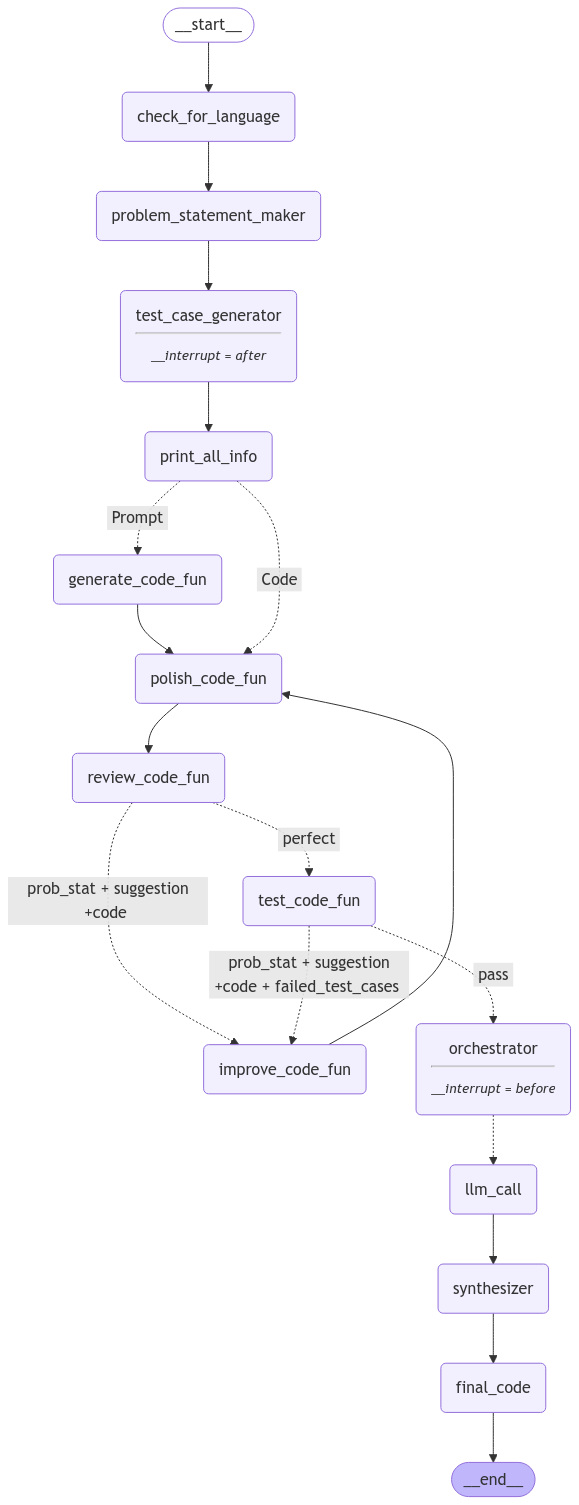

In [164]:
workflow.add_edge(START, "check_for_language")
workflow.add_edge("check_for_language", "problem_statement_maker")
workflow.add_edge("problem_statement_maker", "test_case_generator")
workflow.add_edge("test_case_generator","print_all_info")
workflow.add_conditional_edges("print_all_info", code_prompt_condition, {"Prompt": "generate_code_fun", "Code": "polish_code_fun"})
workflow.add_edge("generate_code_fun", "polish_code_fun")
workflow.add_edge("polish_code_fun", "review_code_fun")
workflow.add_conditional_edges("review_code_fun",condition_at_review,{"perfect":"test_code_fun","prob_stat + suggestion +code":"improve_code_fun"})
workflow.add_edge("improve_code_fun","polish_code_fun")
workflow.add_conditional_edges("test_code_fun",condition_at_test,{"prob_stat + suggestion +code + failed_test_cases":"improve_code_fun","pass":"orchestrator"})
workflow.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
workflow.add_edge("llm_call", "synthesizer")
workflow.add_edge("synthesizer", "final_code")
workflow.add_edge("final_code",END)

memory = MemorySaver()

chain = workflow.compile(checkpointer=memory,interrupt_after=["test_case_generator"], interrupt_before=["orchestrator"])

display(Image(chain.get_graph().draw_mermaid_png()))


In [165]:
initial_input = {"user_prompt":input()}
thread={"configurable":{"thread_id":"1"}}

for event in chain.stream(initial_input, thread, stream_mode="values"):
    print("")

update=input()

for event in chain.stream(None, thread, stream_mode="values"):
    print("")

update=input()

for event in chain.stream(None, thread, stream_mode="values"):
    print("")


# check_language 
 python

# problem_statement_maker 
 ### Problem Statement

You are given two strings: `s` and `p`, where `p` contains exactly two '*' characters. The '*' in `p` acts as a wildcard that can match any sequence of zero or more characters. Your task is to find the shortest substring within `s` that matches the pattern `p`. If multiple substrings of the same minimal length match `p`, return the length of any one of these substrings. If no matching substring exists, return `-1`.

#### Input
- A string `s` (1 ≤ |s| ≤ 10^5), consisting only of lowercase English letters.
- A pattern `p` (2 ≤ |p| ≤ 10^5), consisting of lowercase English letters and exactly two '*' characters.

#### Output
- An integer representing the length of the shortest substring in `s` that matches the pattern `p`. If no such substring exists, return `-1`.

#### Examples

**Example 1:**
- Input: `s = "abaacbaecebce", p = "ba*c*ce"`
- Output: `8`
- Explanation: The shortest matching substring of `p` in `s

In [166]:
state=chain.get_state(thread)
state.next

()

In [167]:
print(state['code'])

TypeError: tuple indices must be integers or slices, not str

In [ ]:
state

{'user_prompt': 'factorial of a number',
 'prompt': 'factorial of a number',
 'problem_statement': 'Certainly! Below is a problem statement for generating the factorial of a number:\n\n---\n\n**Problem Statement: Factorial Calculation**\n\n**Objective:** Write a program that calculates the factorial of a given non-negative integer.\n\n**Task Description:** The factorial of a non-negative integer \\( n \\), denoted by \\( n! \\), is the product of all positive integers less than or equal to \\( n \\). For example, the factorial of 5 (\\( 5! \\)) is calculated as \\( 5 \\times 4 \\times 3 \\times 2 \\times 1 = 120 \\). By convention, the factorial of 0 (\\( 0! \\)) is defined to be 1.\n\n**Input:** A single non-negative integer \\( n \\) (\\( 0 \\leq n \\leq 20 \\)).\n\n**Output:** The factorial of the input integer \\( n \\).\n\n**Example:**\n\n- **Input:** 5\n  **Output:** 120\n- **Input:** 0\n  **Output:** 1\n- **Input:** 3\n  **Output:** 6\n\n**Note:** Ensure that your solution can h

In [ ]:
print(state["final_report"])

```python
def factorial(n):
    """
    Calculate the factorial of a given number.

    Args:
        n (int): The number to calculate the factorial of.

    Returns:
        int: The factorial of the number.

    Raises:
        ValueError: If the input is a negative integer.
    """
    if n < 0:
        raise ValueError("Factorial is not defined for negative numbers")
    if n == 0:
        return 1
    # Recursive call to calculate factorial
    return n * factorial(n - 1)
```


In [ ]:
print(state["completed_sections"])

['```python\ndef factorial(n):\n    """\n    Calculate the factorial of a given number.\n\n    Args:\n        n (int): The number to calculate the factorial of.\n\n    Returns:\n        int: The factorial of the number.\n\n    Raises:\n        ValueError: If the input is a negative integer.\n    """\n    if n < 0:\n        raise ValueError("Factorial is not defined for negative numbers")\n    if n == 0:\n        return 1\n    # Recursive call to calculate factorial\n    return n * factorial(n - 1)\n```']


In [ ]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field
from langgraph.constants import Send


class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


planner = llm.with_structured_output(Sections)

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

def orchestrator(state: State):

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the given code to write production level Docstrings, Comments and Description."),
            HumanMessage(content=f"Here is the report topic: {state["code"]}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

In [ ]:
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]